In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta

# Financial Market Signal on 5 time series  
- Chose Apple, SP500, 20+ years Tresury Bond ETF, GBPUSD, SPDR Gold Trust.  
 - 3 full years, daily timeframes - 2020-2023  
 - EMA 20 and EMA 50 crossing + RSI filter (not overbought or oversold)  

## Initial preparation of the data and signals

In [239]:
tickers = ["AAPL", "SPY", "TLT", "GBPUSD=X", "GLD"]
start_date = "2020-01-01"
end_date = "2023-12-31"

short_ema_period = 20
long_ema_period = 50  
rsi_period = 14
rsi_upper = 70
rsi_lower = 30


In [240]:
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')


[*********************100%***********************]  5 of 5 completed


In [241]:
signals_data = {}

for ticker in tickers:
    df = data[ticker].dropna()

    # Calculate EMAs
    df['Short EMA'] = ta.EMA(df['Close'], timeperiod=short_ema_period)
    df['Long EMA'] = ta.EMA(df['Close'], timeperiod=long_ema_period)

    # Calculate RSI
    df['RSI'] = ta.RSI(df['Close'], timeperiod=rsi_period)

    # Generate Buy/Sell Signals
    df['Signal'] = 0

    # Buy Signal: Short EMA crosses above Long EMA and RSI in neutral range
    df.loc[
        (df['Short EMA'] > df['Long EMA']) &
        (df['Short EMA'].shift(1) <= df['Long EMA'].shift(1)) &  
        (df['RSI'] > rsi_lower) &
        (df['RSI'] < rsi_upper),
        'Signal'
    ] = 1  # 1 = Buy Signal

    # Sell Signal: Short EMA crosses below Long EMA and RSI in neutral range
    df.loc[
        (df['Short EMA'] < df['Long EMA']) &
        (df['Short EMA'].shift(1) >= df['Long EMA'].shift(1)) & 
        (df['RSI'] > rsi_lower) &
        (df['RSI'] < rsi_upper),
        'Signal'
    ] = -1  # -1 = Sell Signal

    signals_data[ticker] = df


## First visualization and performance of the signal


### EMA signal plots

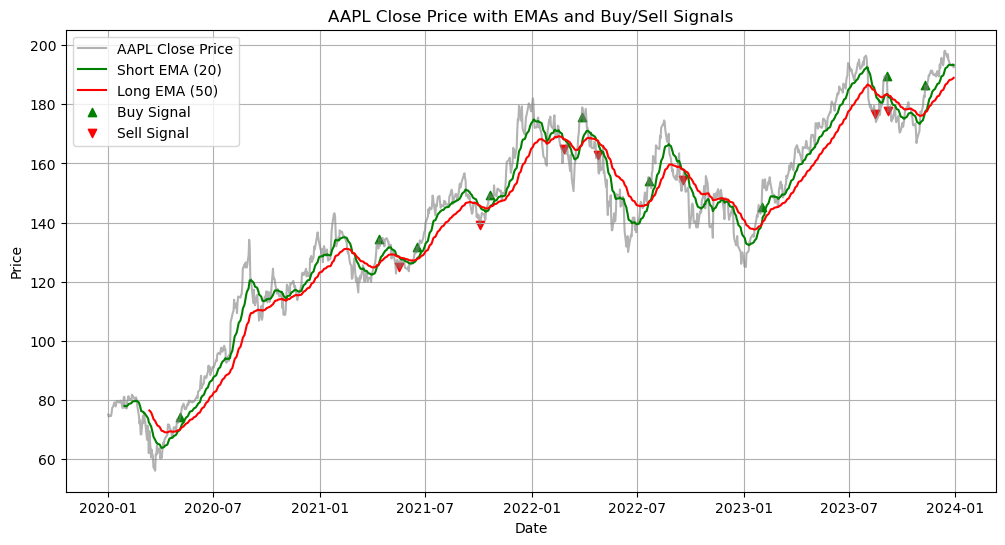

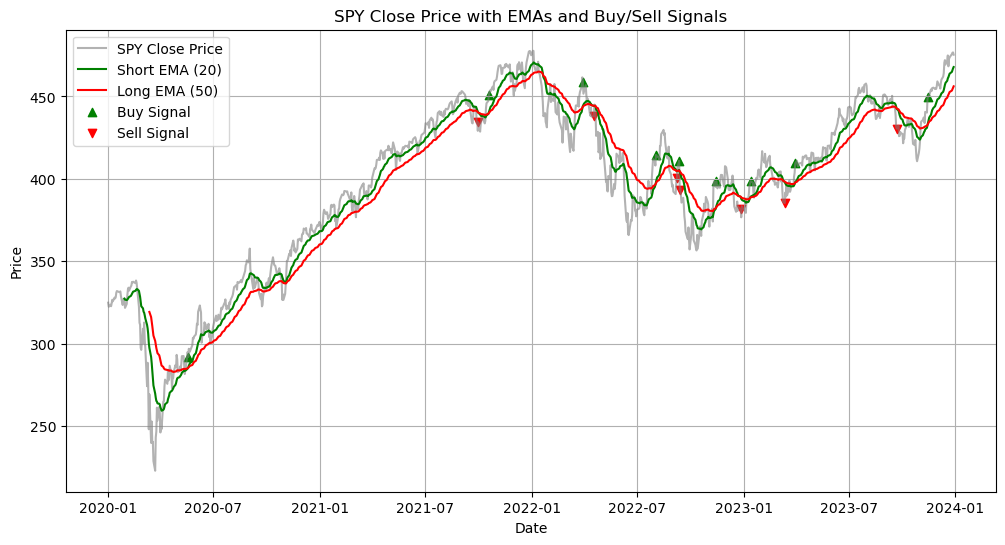

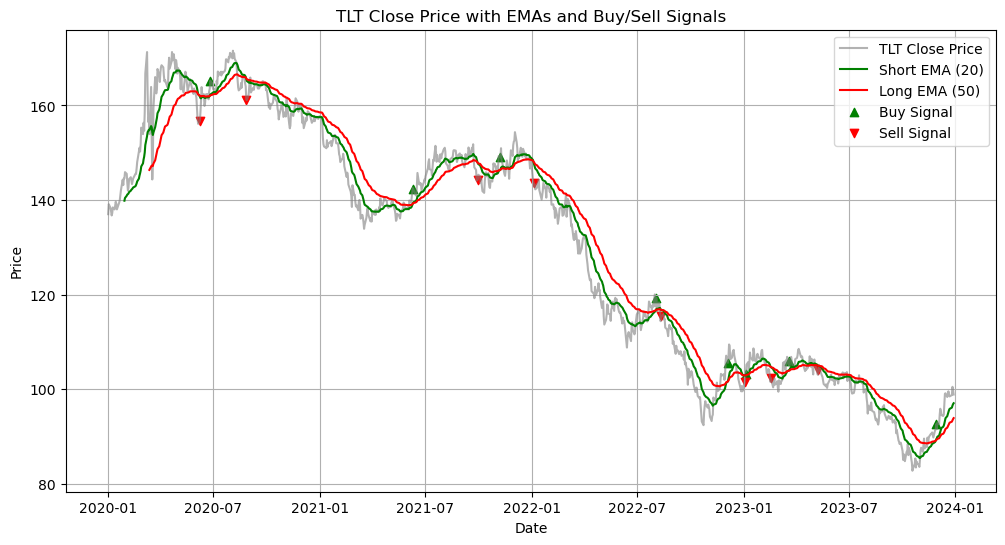

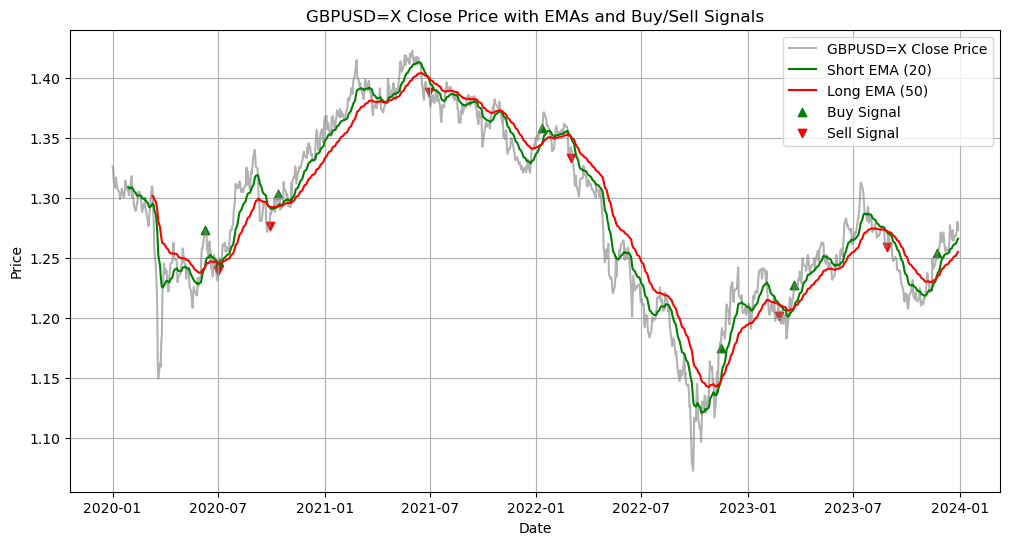

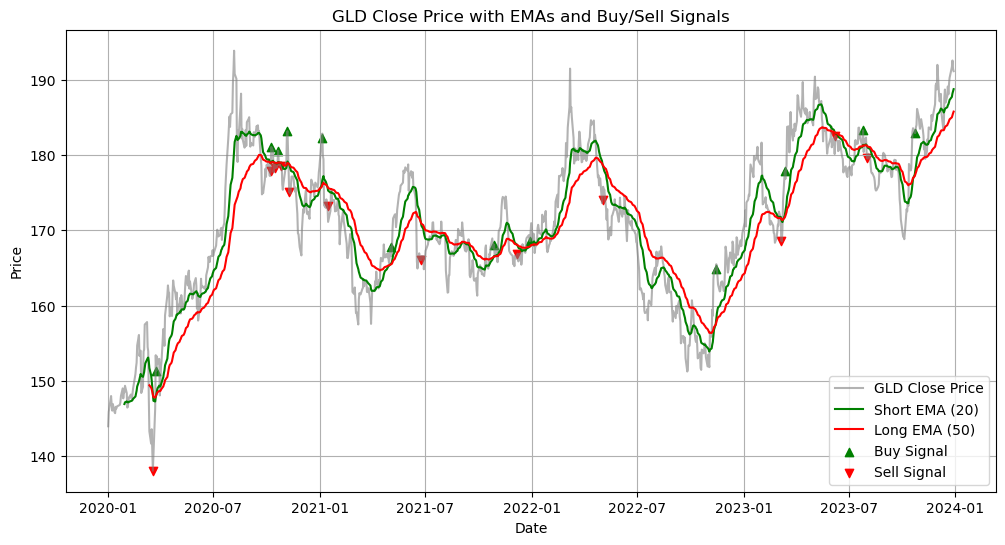

In [242]:
for ticker, df in signals_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label=f'{ticker} Close Price', color='grey', alpha=0.6)
    plt.plot(df.index, df['Short EMA'], label='Short EMA (20)', color='green')
    plt.plot(df.index, df['Long EMA'], label='Long EMA (50)', color='red')

    # Mark buy signals
    buy_signals = df[df['Signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)

    # Mark sell signals
    sell_signals = df[df['Signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

    plt.title(f"{ticker} Close Price with EMAs and Buy/Sell Signals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


### EMA+RSI signal plots

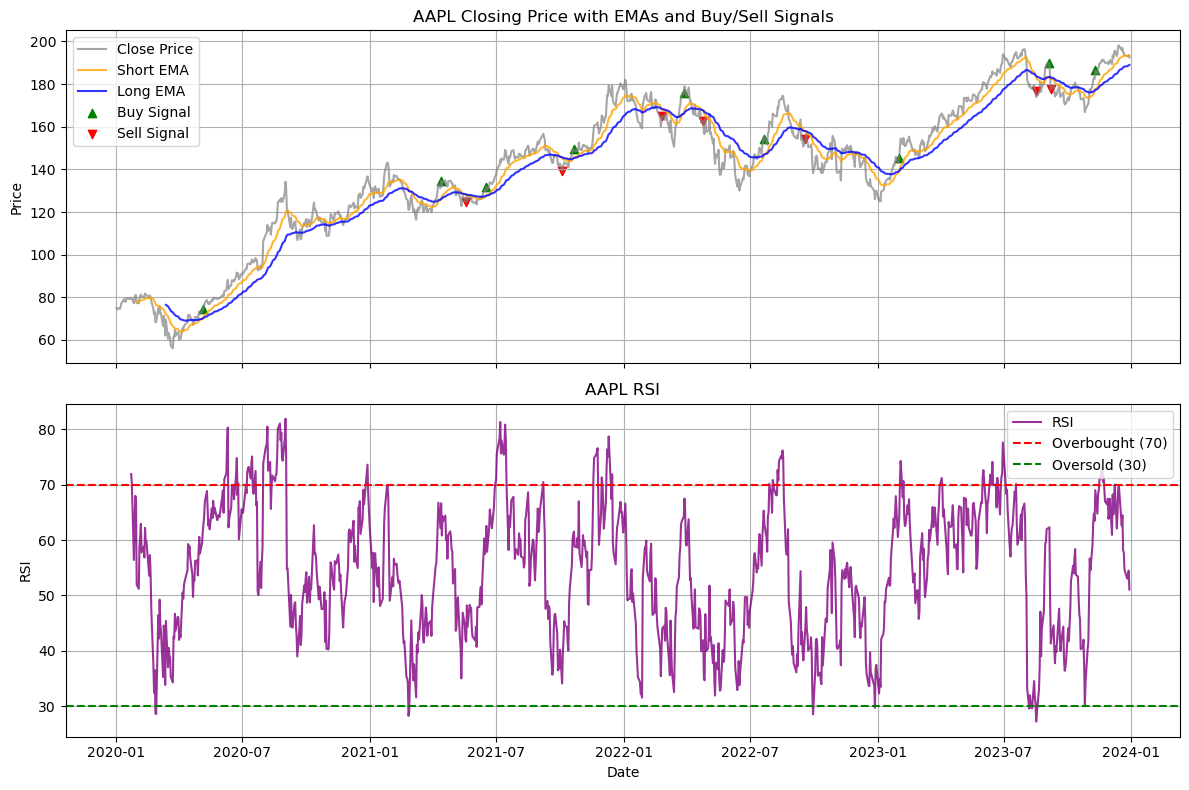

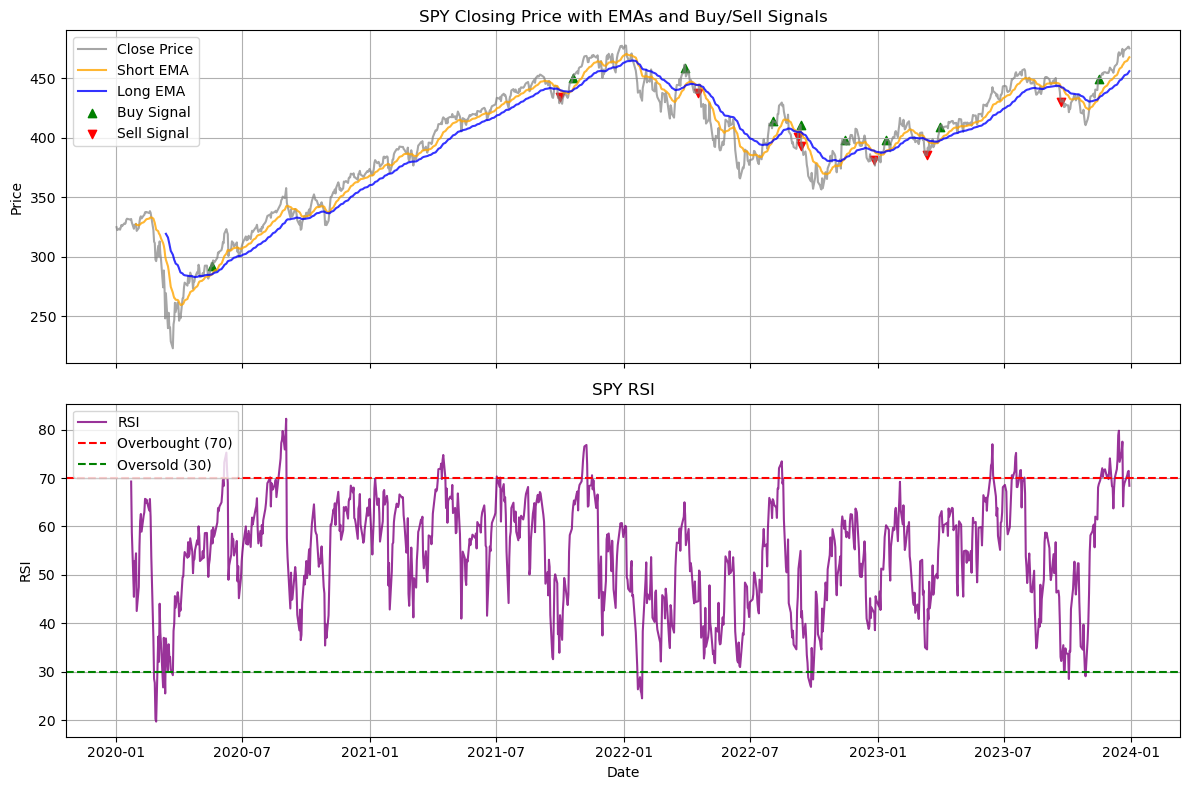

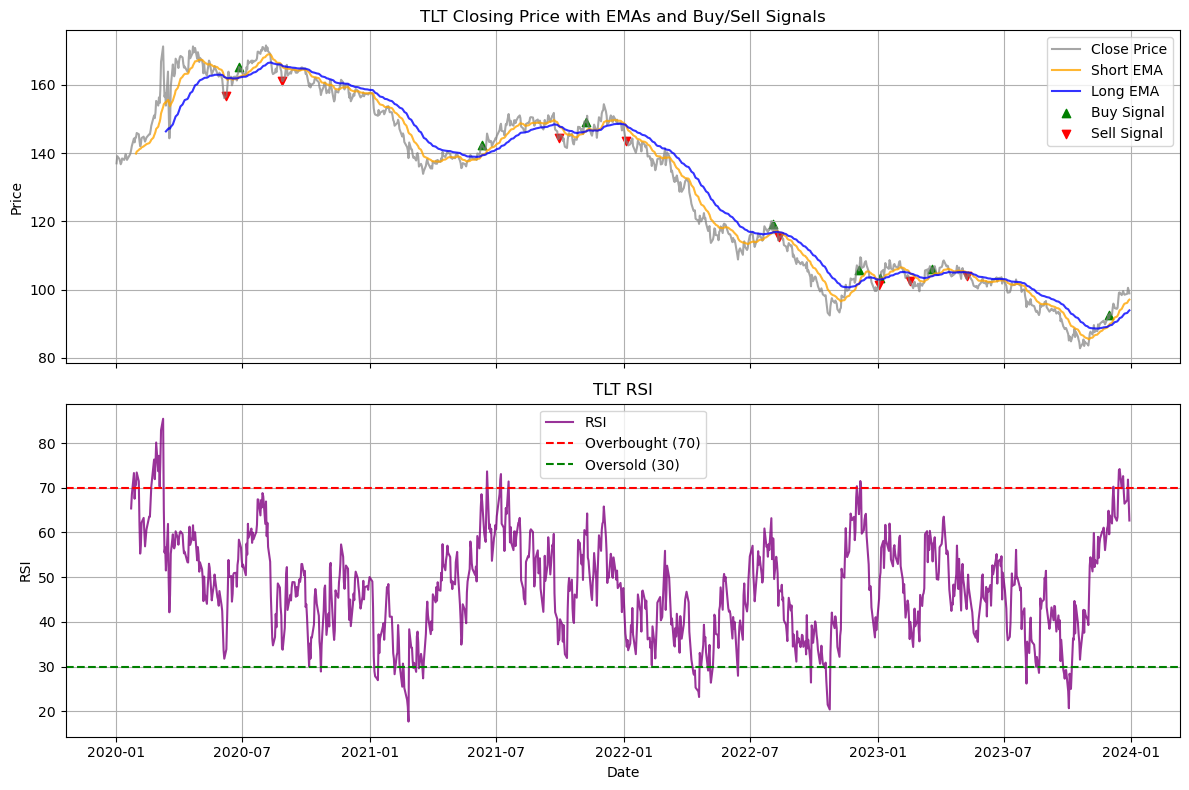

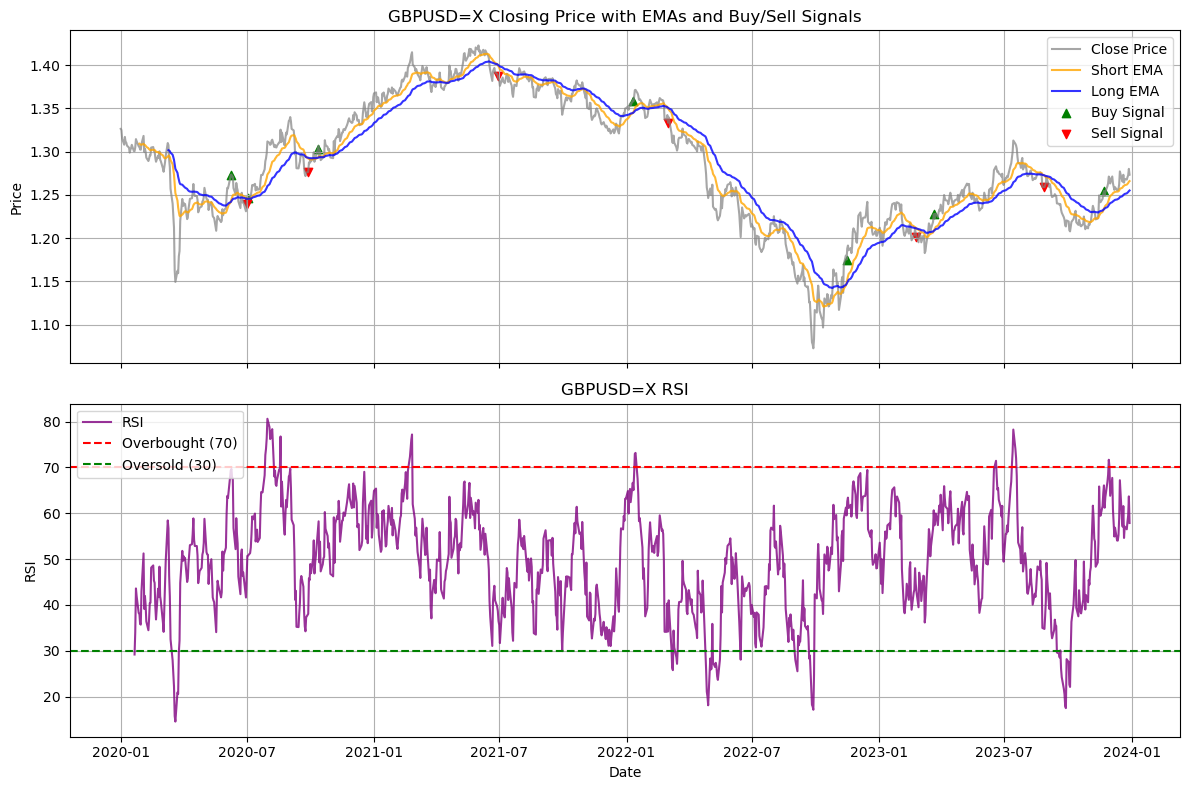

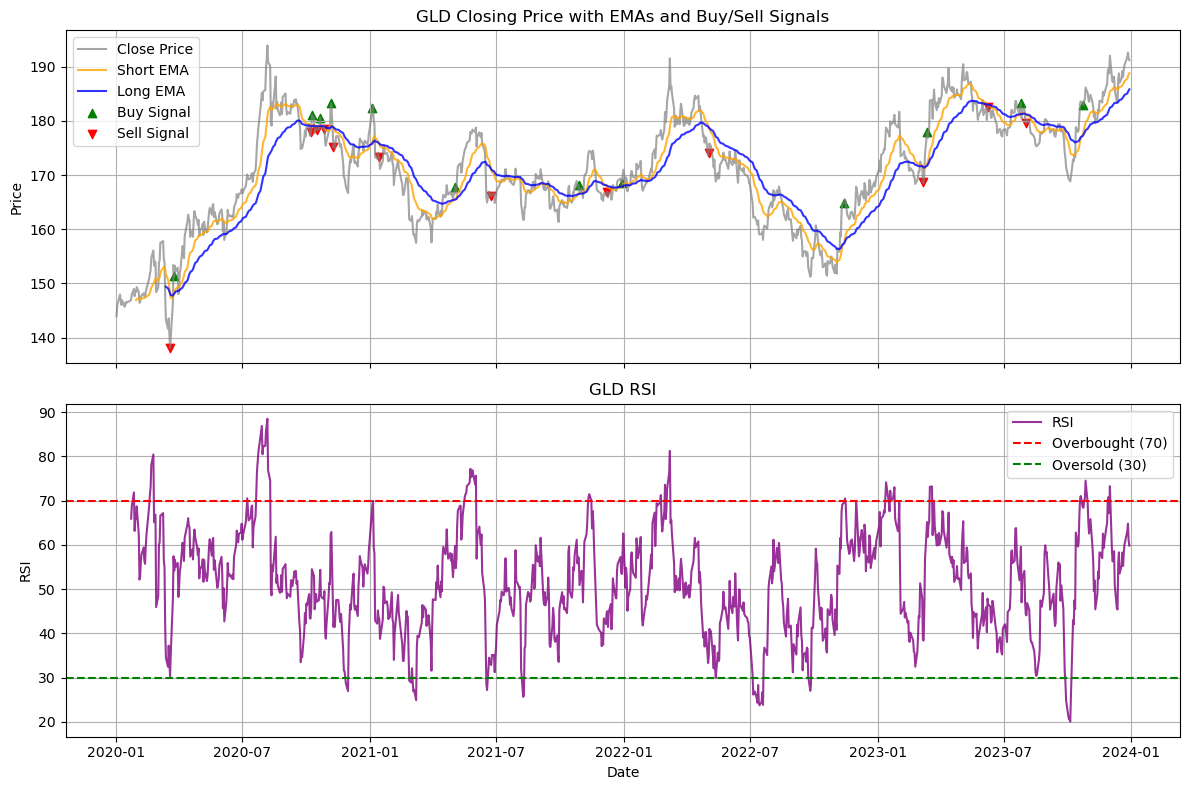

In [243]:
def plot_rsi_and_ema_for_assets(signals_data, tickers=None):
    """
    Plot RSI, EMAs, and closing price with signals for selected assets.
    If no tickers are specified, plot for all assets in signals_data.
    """
    if tickers is None:
        tickers = signals_data.keys()

    for ticker in tickers:
        df = signals_data[ticker]
        
        # Subplots for price and RSI
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        
        # Plot closing price, EMAs, and signals
        ax1.plot(df.index, df['Close'], label="Close Price", color="grey", alpha=0.7)
        ax1.plot(df.index, df['Short EMA'], label="Short EMA", color="orange", alpha=0.8)
        ax1.plot(df.index, df['Long EMA'], label="Long EMA", color="blue", alpha=0.8)
        ax1.scatter(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Close'], 
                    label="Buy Signal", marker="^", color="green", alpha=1)
        ax1.scatter(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Close'], 
                    label="Sell Signal", marker="v", color="red", alpha=1)
        ax1.set_title(f"{ticker} Closing Price with EMAs and Buy/Sell Signals")
        ax1.set_ylabel("Price")
        ax1.legend()
        ax1.grid()

        # Plot RSI
        ax2.plot(df.index, df['RSI'], label="RSI", color="purple", alpha=0.8)
        ax2.axhline(70, color="red", linestyle="--", label="Overbought (70)")
        ax2.axhline(30, color="green", linestyle="--", label="Oversold (30)")
        ax2.set_title(f"{ticker} RSI")
        ax2.set_ylabel("RSI")
        ax2.legend()
        ax2.grid()

        plt.xlabel("Date")
        plt.tight_layout()
        plt.show()

plot_rsi_and_ema_for_assets(signals_data)


### Backtest and returns of the first iteration  
First iteration contains only long positions

In [244]:
def backtest_signals_fixed(df, trade_capital=10000):
    """
    Backtest using a fixed capital ($10,000) for each trade.
    Profits/losses are added to a cumulative balance.
    """
    total_profit = 0  # tracks cumulative profit/loss
    position = 0  # track if holding an asset (number of units)
    entry_price = 0

    for index, row in df.iterrows():
        if row['Signal'] == 1 and position == 0:  # Buy
            entry_price = row['Close']
            position = trade_capital / entry_price  # Number of units to buy
        elif row['Signal'] == -1 and position > 0:  # Sell
            trade_profit = position * (row['Close'] - entry_price)  # Profit/Loss in USD
            total_profit += trade_profit  # Add to cumulative profit
            position = 0  # Exit position

    # If still holding a position at the end, liquidate position
    if position > 0:
        trade_profit = position * (df.iloc[-1]['Close'] - entry_price)
        total_profit += trade_profit

    return trade_capital + total_profit, (total_profit / trade_capital) * 100


#### Evaluate and display performance 

In [245]:
performance_results_fixed = {}

for ticker, df in signals_data.items():
    final_balance, return_pct = backtest_signals_fixed(df)
    performance_results_fixed[ticker] = {
        'Final Balance': final_balance,
        'Return (%)': return_pct
    }

performance_fixed_df = pd.DataFrame(performance_results_fixed).T
print(performance_fixed_df)

          Final Balance  Return (%)
AAPL       19500.186371   95.001864
SPY        14142.339740   41.423397
TLT         9244.018285   -7.559817
GBPUSD=X   11071.295772   10.712958
GLD        11427.117387   14.271174


### Equity curves for the first iteration - long only

In [246]:
def calculate_portfolio_equity_curve(signals_data, trade_capital=10000):
    """
    Calculate the portfolio equity curve by aggregating individual asset equity curves.
    """
    portfolio_equity_curve = None

    for ticker, df in signals_data.items():
        equity_curve = []
        total_profit = 0
        position = 0  # Track if holding an asset (number of units)
        entry_price = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1 and position == 0:  # Buy
                entry_price = row['Close']
                position = trade_capital / entry_price  # Units to buy
            elif row['Signal'] == -1 and position > 0:  # Sell
                trade_profit = position * (row['Close'] - entry_price)
                total_profit += trade_profit
                position = 0  # Exit position
            equity_curve.append(total_profit)

        while len(equity_curve) < len(df.index):
            equity_curve.append(total_profit)

        # Convert to DataFrame and align dates
        df_equity = pd.DataFrame(equity_curve, index=df.index, columns=[ticker])
        if portfolio_equity_curve is None:
            portfolio_equity_curve = df_equity
        else:
            portfolio_equity_curve = portfolio_equity_curve.join(df_equity, how='outer')

    # Fill missing values and sum across all assets
    portfolio_equity_curve = portfolio_equity_curve.fillna(method="ffill").fillna(0)
    portfolio_equity_curve["Portfolio"] = portfolio_equity_curve.sum(axis=1)
    return portfolio_equity_curve


/var/folders/r1/d5qf53jn5hx_mktynlc6c5nm0000gn/T/ipykernel_33253/3092108660.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  portfolio_equity_curve = portfolio_equity_curve.fillna(method="ffill").fillna(0)


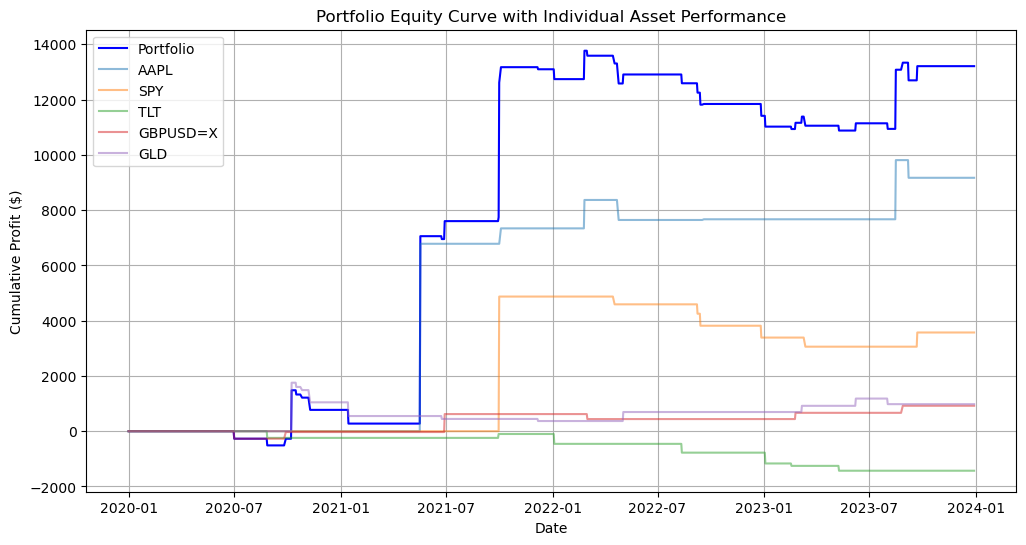

In [268]:
portfolio_equity_curve = calculate_portfolio_equity_curve(signals_data)

plt.figure(figsize=(12, 6))
plt.plot(portfolio_equity_curve.index, portfolio_equity_curve["Portfolio"], label="Portfolio", color="blue")
for ticker in signals_data.keys():
    plt.plot(portfolio_equity_curve.index, portfolio_equity_curve[ticker], label=ticker, alpha=0.5)
plt.title("Portfolio Equity Curve with Individual Asset Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid()
plt.show()


### Metrics v1

In [248]:
def calculate_metrics(signals_data, trade_capital=10000):
    """
    Calculate Sharpe Ratio and Win Rate for each asset.
    """
    results = {}

    for ticker, df in signals_data.items():
        equity_curve = []
        total_profit = 0
        position = 0
        entry_price = 0
        daily_returns = []
        wins = 0
        trades = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1 and position == 0:  # Buy
                entry_price = row['Close']
                position = trade_capital / entry_price
            elif row['Signal'] == -1 and position > 0:  # Sell
                trade_profit = position * (row['Close'] - entry_price)
                total_profit += trade_profit
                daily_returns.append(trade_profit / trade_capital)  # Normalize by trade capital
                position = 0  # Exit position
                trades += 1
                if trade_profit > 0:
                    wins += 1

        # Calculate metrics
        avg_daily_return = np.mean(daily_returns)
        std_daily_return = np.std(daily_returns)
        sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else 0
        win_rate = wins / trades if trades > 0 else 0

        results[ticker] = {
            "Sharpe Ratio": sharpe_ratio,
            "Win Rate (%)": win_rate * 100,
            "Total Trades": trades,
        }

    return pd.DataFrame(results).T

performance_metrics = calculate_metrics(signals_data)
print(performance_metrics)

          Sharpe Ratio  Win Rate (%)  Total Trades
AAPL          0.542138     71.428571           7.0
SPY           0.282400     28.571429           7.0
TLT          -1.189525     14.285714           7.0
GBPUSD=X      0.500852     66.666667           6.0
GLD           0.152337     36.363636          11.0


## Second iteration

### Included shorts - incorrect calculation of the PnL, backtesting and debugging

In [249]:
def backtest_with_shorts(df, trade_capital=10000):
    """
    Backtest the strategy with long and short positions.
    """
    equity_curve = []
    total_profit = 0
    position = 0  # Positive for long, negative for short
    entry_price = 0

    for index, row in df.iterrows():
        if row['Signal'] == 1:  # Buy Signal
            if position < 0:  # Close short position
                total_profit += position * (entry_price - row['Close'])
                position = 0
            if position == 0:  # Open long position
                entry_price = row['Close']
                position = trade_capital / entry_price  # Units to buy
        elif row['Signal'] == -1:  # Sell Signal
            if position > 0:  # Close long position
                total_profit += position * (row['Close'] - entry_price)
                position = 0
            if position == 0:  # Open short position
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Units to short
        equity_curve.append(total_profit)

    # If still holding a position at the end, liquidate it
    if position > 0:  # Long position
        total_profit += position * (df.iloc[-1]['Close'] - entry_price)
    elif position < 0:  # Short position
        total_profit += position * (entry_price - df.iloc[-1]['Close'])

    # Ensure the equity curve matches the index length
    equity_curve = equity_curve[:len(df.index)]

    return equity_curve, total_profit


In [250]:
signals_data = {}

for ticker in tickers:
    df = data[ticker].dropna()

    df['Short EMA'] = ta.EMA(df['Close'], timeperiod=short_ema_period)
    df['Long EMA'] = ta.EMA(df['Close'], timeperiod=long_ema_period)

    df['RSI'] = ta.RSI(df['Close'], timeperiod=rsi_period)

    df['Signal'] = 0

    # Buy Signal: Short EMA crosses above Long EMA and RSI in neutral range
    df.loc[
        (df['Short EMA'] > df['Long EMA']) &
        (df['Short EMA'].shift(1) <= df['Long EMA'].shift(1)) &  
        (df['RSI'] > rsi_lower) & (df['RSI'] < rsi_upper),
        'Signal'
    ] = 1  # Buy Signal

    # Sell Signal: Short EMA crosses below Long EMA and RSI in neutral range
    df.loc[
        (df['Short EMA'] < df['Long EMA']) &
        (df['Short EMA'].shift(1) >= df['Long EMA'].shift(1)) &  
        (df['RSI'] > rsi_lower) & (df['RSI'] < rsi_upper),
        'Signal'
    ] = -1  # Sell Signal

    # Backtest and calculate equity curve
    df['Equity Curve'], _ = backtest_with_shorts(df)
    signals_data[ticker] = df


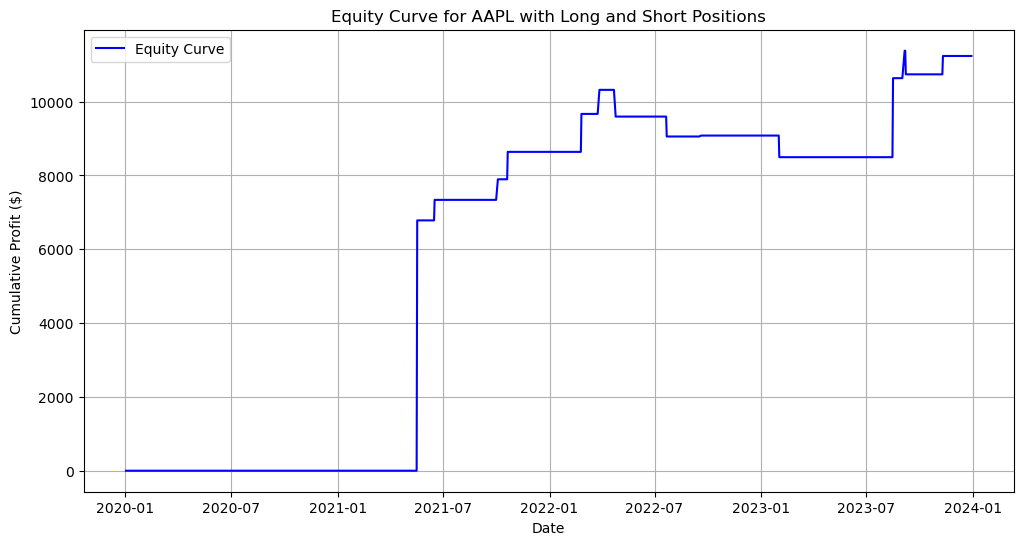

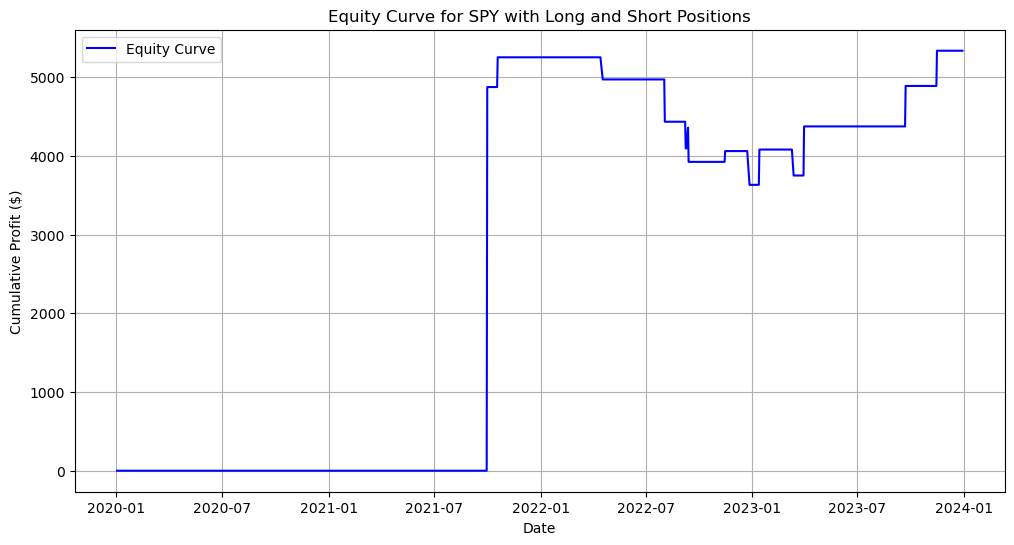

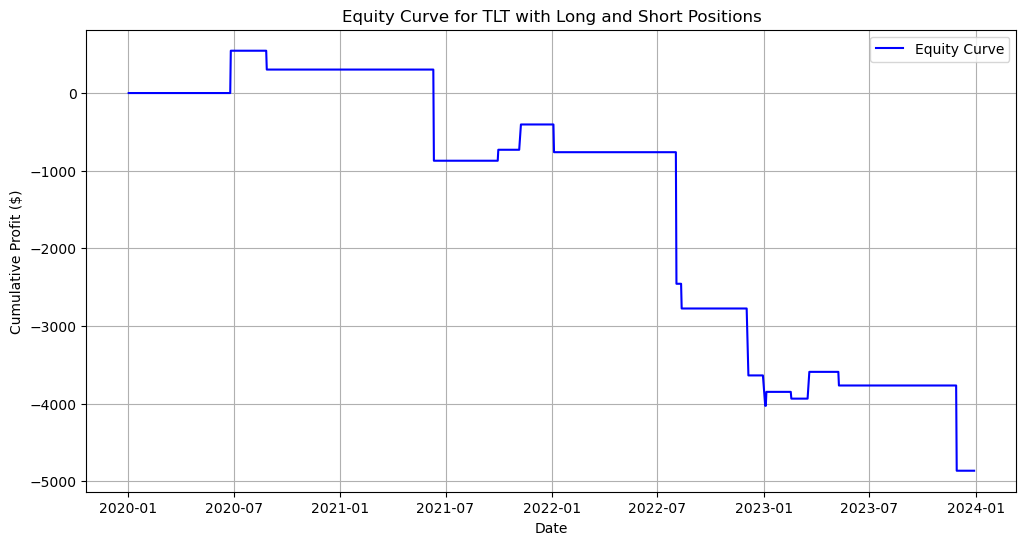

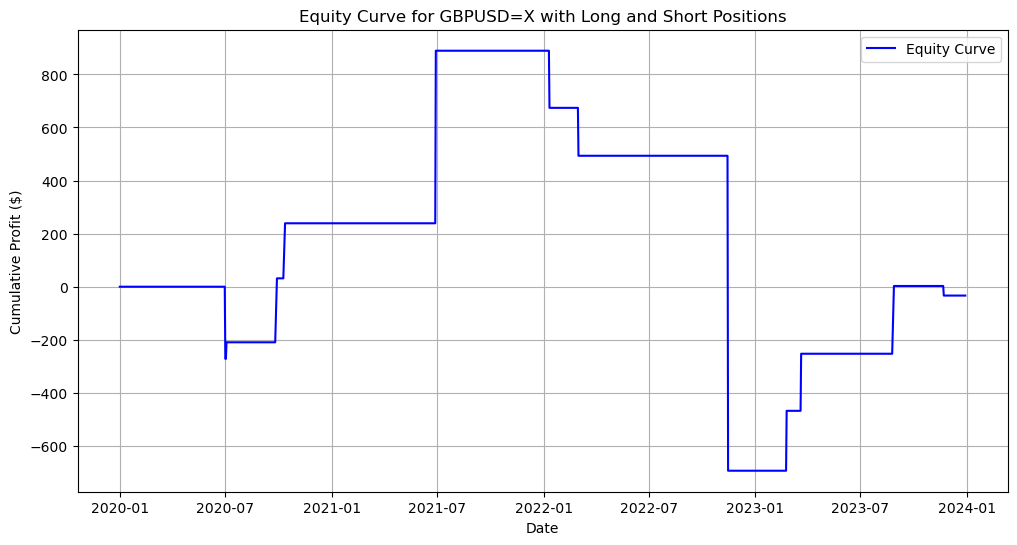

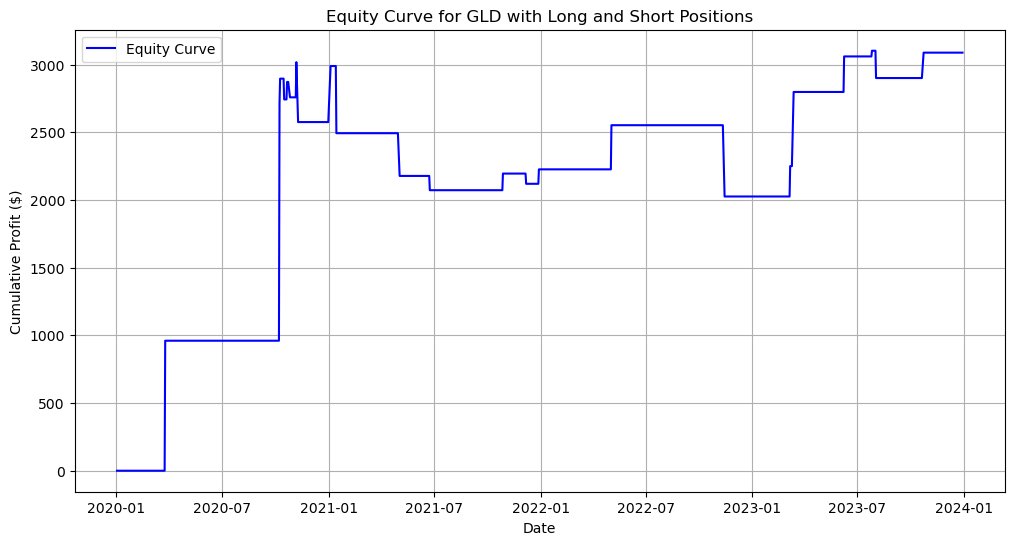

In [251]:
def plot_individual_equity_curves(signals_data):
    """
    Plot individual equity curves for each asset.
    """
    for ticker, df in signals_data.items():
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Equity Curve'], label="Equity Curve", color="blue")
        plt.title(f"Equity Curve for {ticker} with Long and Short Positions")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Profit ($)")
        plt.legend()
        plt.grid()
        plt.show()

plot_individual_equity_curves(signals_data)


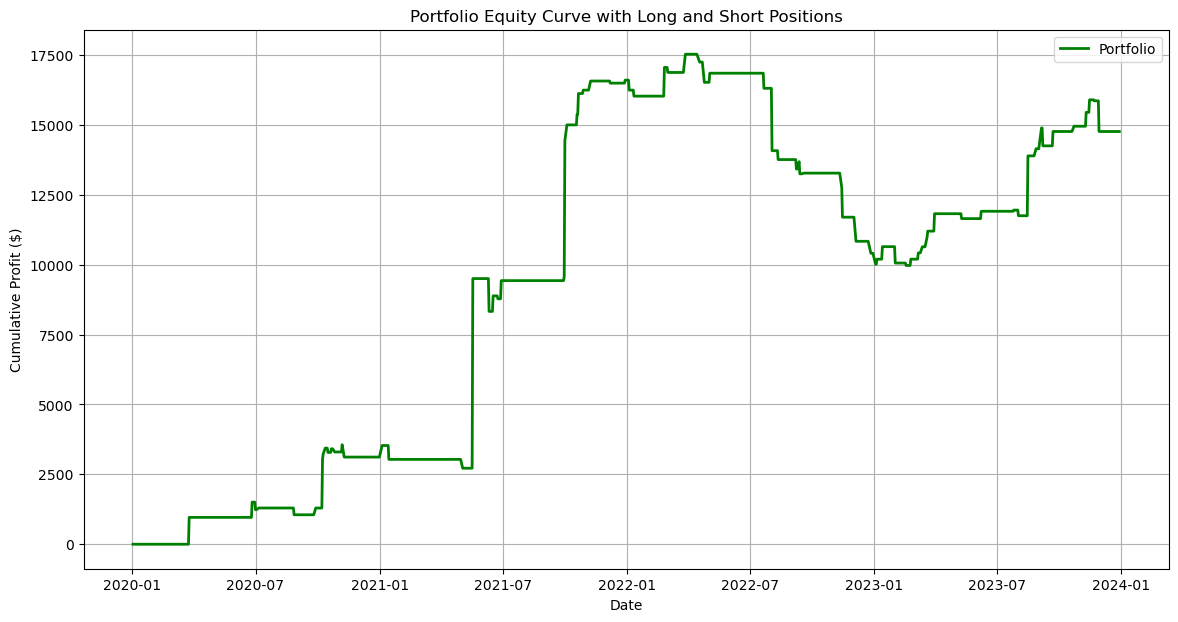

In [252]:
def plot_portfolio_equity(signals_data):
    """
    Plot the portfolio equity curve by summing individual asset equity curves.
    """
    portfolio_equity_curve = None
    for ticker, df in signals_data.items():
        if portfolio_equity_curve is None:
            portfolio_equity_curve = df['Equity Curve']
        else:
            portfolio_equity_curve += df['Equity Curve']

    plt.figure(figsize=(14, 7))
    plt.plot(signals_data[next(iter(signals_data))].index, portfolio_equity_curve, label="Portfolio", color="green", linewidth=2)
    plt.title("Portfolio Equity Curve with Long and Short Positions")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit ($)")
    plt.legend()
    plt.grid()
    plt.show()

# Plot portfolio equity curve
plot_portfolio_equity(signals_data)


In [253]:
def backtest_with_shorts_debug(df, trade_capital=10000):
    """
    Backtest the strategy with long and short positions and debug trade recording.
    """
    equity_curve = []
    trades = []  # Record trades for debugging
    total_profit = 0
    position = 0  # Positive for long, negative for short
    entry_price = 0

    for index, row in df.iterrows():
        if row['Signal'] == 1:  # Buy Signal
            if position < 0:  # Close short position
                profit = position * (entry_price - row['Close'])
                total_profit += profit
                trades.append((index, "Short Closed", profit))
                position = 0
            if position == 0:  # Open long position
                entry_price = row['Close']
                position = trade_capital / entry_price  # Units to buy
                trades.append((index, "Long Opened", 0))
        elif row['Signal'] == -1:  # Sell Signal
            if position > 0:  # Close long position
                profit = position * (row['Close'] - entry_price)
                total_profit += profit
                trades.append((index, "Long Closed", profit))
                position = 0
            if position == 0:  # Open short position
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Units to short
                trades.append((index, "Short Opened", 0))
        equity_curve.append(total_profit)

    # If still holding a position at the end, liquidate it
    if position > 0:  # Long position
        profit = position * (df.iloc[-1]['Close'] - entry_price)
        total_profit += profit
        trades.append((df.index[-1], "Long Closed (End)", profit))
    elif position < 0:  # Short position
        profit = position * (entry_price - df.iloc[-1]['Close'])
        total_profit += profit
        trades.append((df.index[-1], "Short Closed (End)", profit))

    equity_curve = equity_curve[:len(df.index)]
    return equity_curve, trades


                        Date             Action       Profit
0  2020-06-08 00:00:00+00:00       Short Opened     0.000000
1  2020-06-26 00:00:00+00:00       Short Closed   544.955199
2  2020-06-26 00:00:00+00:00        Long Opened     0.000000
3  2020-08-27 00:00:00+00:00        Long Closed  -242.662300
4  2020-08-27 00:00:00+00:00       Short Opened     0.000000
5  2021-06-11 00:00:00+00:00       Short Closed -1174.026748
6  2021-06-11 00:00:00+00:00        Long Opened     0.000000
7  2021-09-30 00:00:00+00:00        Long Closed   141.241641
8  2021-09-30 00:00:00+00:00       Short Opened     0.000000
9  2021-11-08 00:00:00+00:00       Short Closed   325.664960
10 2021-11-08 00:00:00+00:00        Long Opened     0.000000
11 2022-01-04 00:00:00+00:00        Long Closed  -356.999542
12 2022-01-04 00:00:00+00:00       Short Opened     0.000000
13 2022-08-03 00:00:00+00:00       Short Closed -1694.502365
14 2022-08-03 00:00:00+00:00        Long Opened     0.000000
15 2022-08-12 00:00:00+0

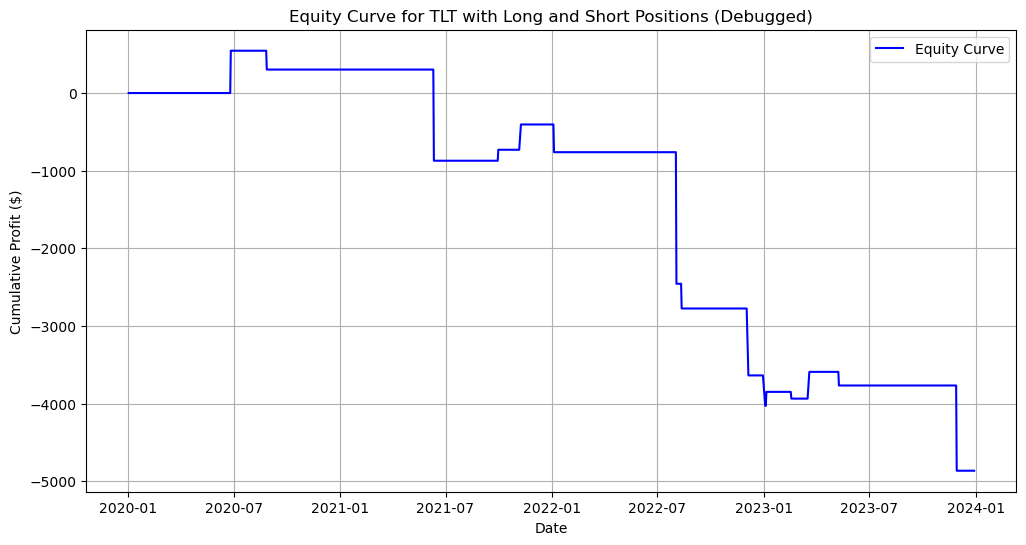

In [254]:
# Apply the updated function to TLT for debugging
tlt_df = signals_data["TLT"]
tlt_df['Equity Curve'], tlt_trades = backtest_with_shorts_debug(tlt_df)

# Debug Trade Log
trade_log_df = pd.DataFrame(tlt_trades, columns=["Date", "Action", "Profit"])
print(trade_log_df)

# Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(tlt_df.index, tlt_df['Equity Curve'], label="Equity Curve", color="blue")
plt.title("Equity Curve for TLT with Long and Short Positions (Debugged)")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid()
plt.show()


### Included shorts - corrected version

In [255]:
def backtest_with_shorts_fixed(df, trade_capital=10000):
    """
    Backtest the strategy with long and short positions, ensuring proper sign for short profits.
    """
    equity_curve = []
    trades = []  # Record trades for potential further debugging
    total_profit = 0
    position = 0  # Positive for long, negative for short
    entry_price = 0

    for index, row in df.iterrows():
        if row['Signal'] == 1:  # Buy Signal
            if position < 0:  # Close short position
                profit = -position * (entry_price - row['Close'])  # Correct sign for short
                total_profit += profit
                trades.append((index, "Short Closed", profit))
                position = 0
            if position == 0:  # Open long position
                entry_price = row['Close']
                position = trade_capital / entry_price  # Units to buy
                trades.append((index, "Long Opened", 0))
        elif row['Signal'] == -1:  # Sell Signal
            if position > 0:  # Close long position
                profit = position * (row['Close'] - entry_price)
                total_profit += profit
                trades.append((index, "Long Closed", profit))
                position = 0
            if position == 0:  # Open short position
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Units to short
                trades.append((index, "Short Opened", 0))
        equity_curve.append(total_profit)

    # If still holding a position at the end, liquidate it
    if position > 0:  # Long position
        profit = position * (df.iloc[-1]['Close'] - entry_price)
        total_profit += profit
        trades.append((df.index[-1], "Long Closed (End)", profit))
    elif position < 0:  # Short position
        profit = -position * (entry_price - df.iloc[-1]['Close'])  # Correct sign for short
        total_profit += profit
        trades.append((df.index[-1], "Short Closed (End)", profit))

    equity_curve = equity_curve[:len(df.index)]
    return equity_curve, trades


                        Date             Action       Profit
0  2020-06-08 00:00:00+00:00       Short Opened     0.000000
1  2020-06-26 00:00:00+00:00       Short Closed  -544.955199
2  2020-06-26 00:00:00+00:00        Long Opened     0.000000
3  2020-08-27 00:00:00+00:00        Long Closed  -242.662300
4  2020-08-27 00:00:00+00:00       Short Opened     0.000000
5  2021-06-11 00:00:00+00:00       Short Closed  1174.026748
6  2021-06-11 00:00:00+00:00        Long Opened     0.000000
7  2021-09-30 00:00:00+00:00        Long Closed   141.241641
8  2021-09-30 00:00:00+00:00       Short Opened     0.000000
9  2021-11-08 00:00:00+00:00       Short Closed  -325.664960
10 2021-11-08 00:00:00+00:00        Long Opened     0.000000
11 2022-01-04 00:00:00+00:00        Long Closed  -356.999542
12 2022-01-04 00:00:00+00:00       Short Opened     0.000000
13 2022-08-03 00:00:00+00:00       Short Closed  1694.502365
14 2022-08-03 00:00:00+00:00        Long Opened     0.000000
15 2022-08-12 00:00:00+0

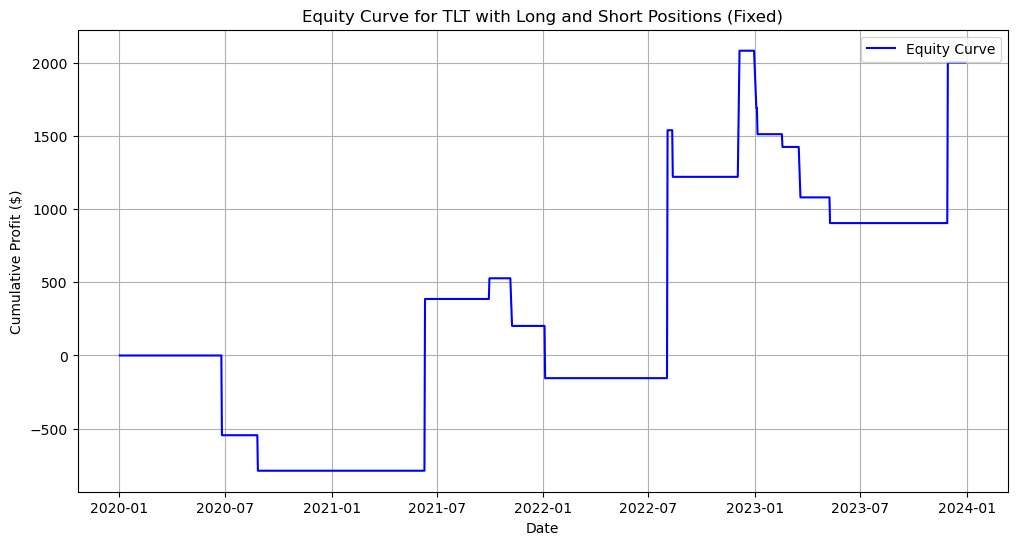

In [256]:
# Apply the updated backtest function to TLT
tlt_df = signals_data["TLT"]
tlt_df['Equity Curve'], tlt_trades_fixed = backtest_with_shorts_fixed(tlt_df)

# Debug Trade Log
trade_log_fixed_df = pd.DataFrame(tlt_trades_fixed, columns=["Date", "Action", "Profit"])
print(trade_log_fixed_df)

# Plot Fixed Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(tlt_df.index, tlt_df['Equity Curve'], label="Equity Curve", color="blue")
plt.title("Equity Curve for TLT with Long and Short Positions (Fixed)")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit ($)")
plt.legend()
plt.grid()
plt.show()


### Second (final) iteration on all assets

In [257]:
# Apply fixed backtest logic to all assets
for ticker, df in signals_data.items():
    df['Equity Curve'], _ = backtest_with_shorts_fixed(df)


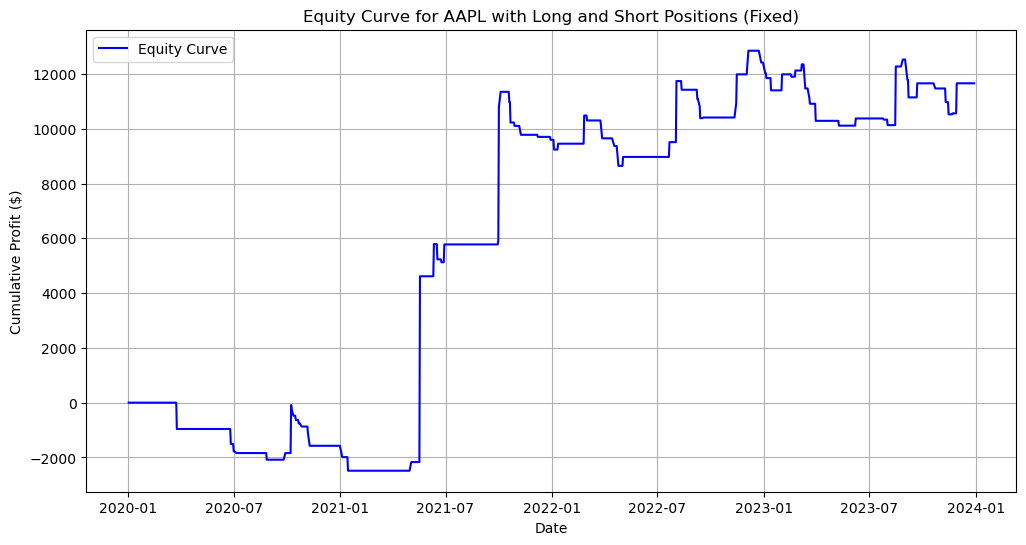

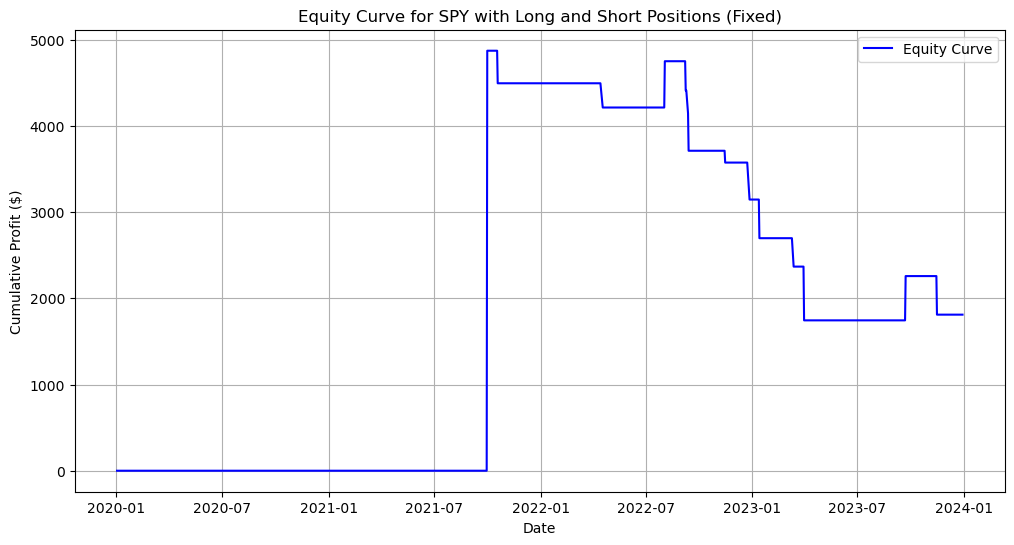

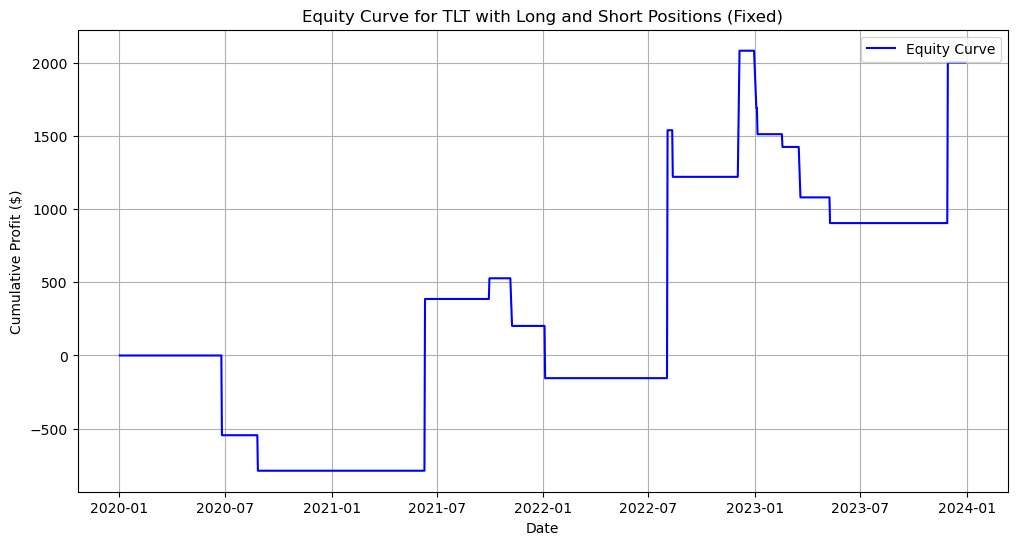

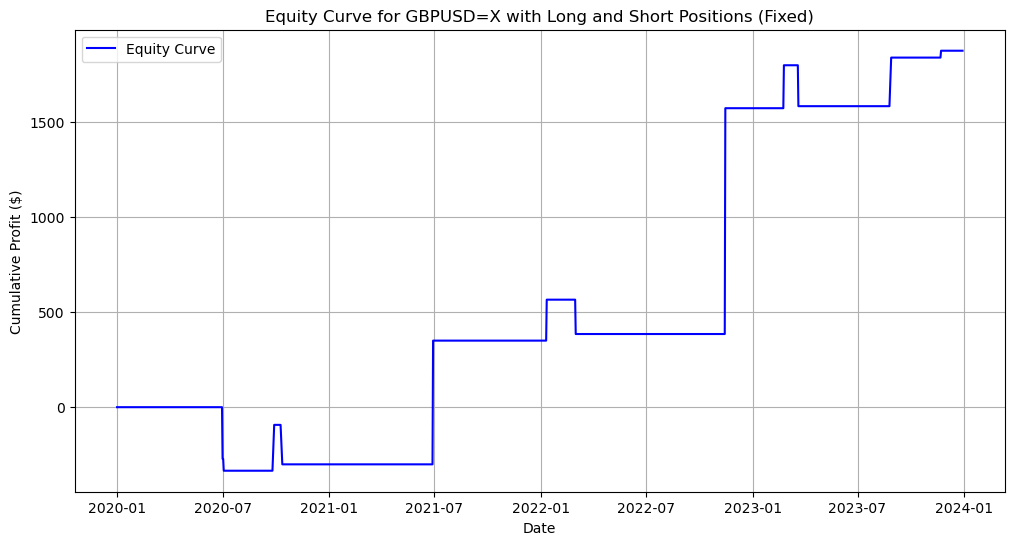

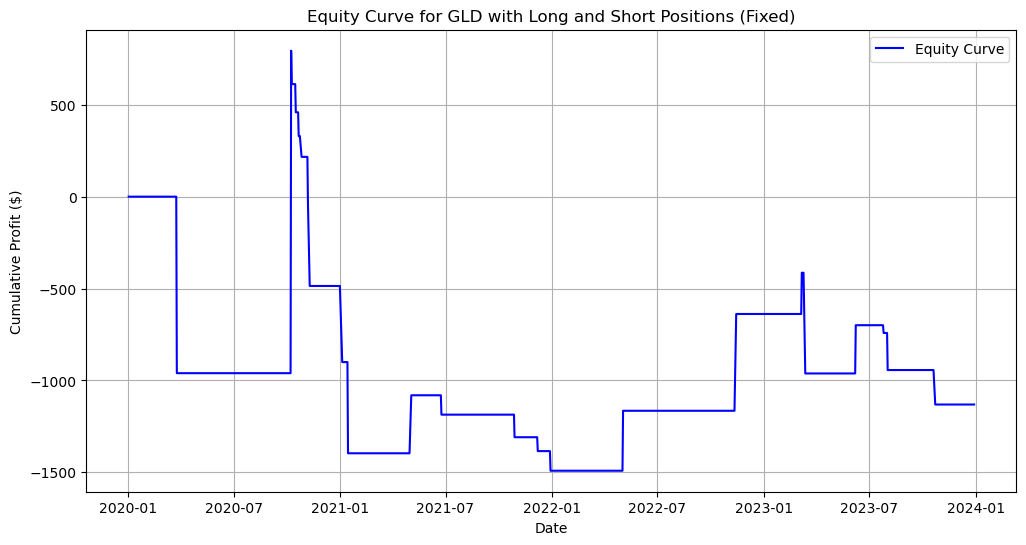

In [269]:
def plot_individual_equity_curves(signals_data):
    """
    Plot individual equity curves for each asset.
    """
    for ticker, df in signals_data.items():
        plt.figure(figsize=(12, 6))
        plt.plot(df.index, df['Equity Curve'], label="Equity Curve", color="blue")
        plt.title(f"Equity Curve for {ticker} with Long and Short Positions (Fixed)")
        plt.xlabel("Date")
        plt.ylabel("Cumulative Profit ($)")
        plt.legend()
        plt.grid()
        plt.show()

plot_individual_equity_curves(signals_data)


### Portfolio performance

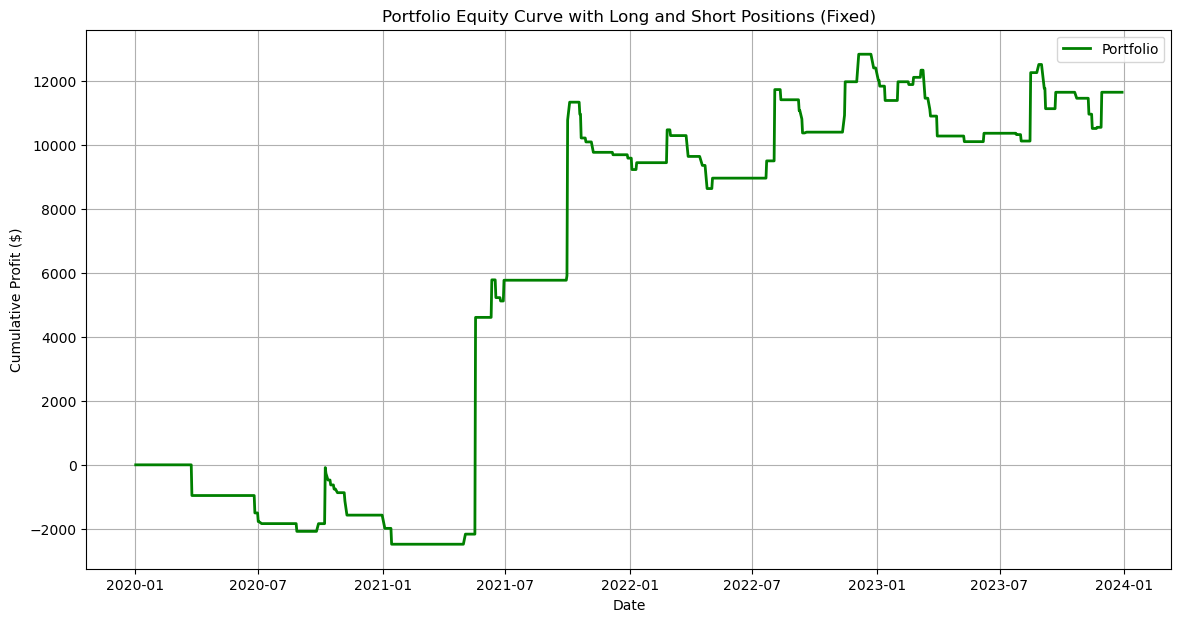

In [ ]:
def plot_portfolio_equity(signals_data):
    """
    Plot the portfolio equity curve by summing individual asset equity curves.
    """
    portfolio_equity_curve = None

    for ticker, df in signals_data.items():
        if portfolio_equity_curve is None:
            portfolio_equity_curve = df['Equity Curve']
        else:
            portfolio_equity_curve += df['Equity Curve']

    plt.figure(figsize=(14, 7))
    plt.plot(signals_data[next(iter(signals_data))].index, portfolio_equity_curve, label="Portfolio", color="green", linewidth=2)
    plt.title("Portfolio Equity Curve with Long and Short Positions (Fixed)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Profit ($)")
    plt.legend()
    plt.grid()
    plt.show()

plot_portfolio_equity(signals_data)


### Final metrics

In [ ]:
def calculate_metrics_fixed(signals_data, trade_capital=10000):
    """
    Calculate Sharpe Ratio, Win Rate, and Total Trades for each asset.
    """
    results = {}

    for ticker, df in signals_data.items():
        equity_curve = df['Equity Curve']
        trades = 0
        profitable_trades = 0

        # Calculate individual trade outcomes
        position = 0
        entry_price = 0
        for index, row in df.iterrows():
            if row['Signal'] == 1:  # Buy signal
                if position < 0:  # Close short
                    trade_profit = -position * (entry_price - row['Close'])
                    if trade_profit > 0:
                        profitable_trades += 1
                    trades += 1
                entry_price = row['Close']
                position = trade_capital / entry_price  # Open long
            elif row['Signal'] == -1:  # Sell signal
                if position > 0:  # Close long
                    trade_profit = position * (row['Close'] - entry_price)
                    if trade_profit > 0:
                        profitable_trades += 1
                    trades += 1
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Open short

        # Calculate daily returns for Sharpe Ratio
        daily_returns = equity_curve.diff().fillna(0) / trade_capital  # Normalize returns
        avg_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()
        sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else 0

        # Calculate Win Rate
        win_rate = (profitable_trades / trades) * 100 if trades > 0 else 0

        # Store results
        results[ticker] = {
            "Sharpe Ratio": sharpe_ratio,
            "Win Rate (%)": win_rate,
            "Total Trades": trades,
            "Final Equity": equity_curve.iloc[-1],
        }

    return pd.DataFrame(results).T


performance_metrics_fixed = calculate_metrics_fixed(signals_data)

print(performance_metrics_fixed)


          Sharpe Ratio  Win Rate (%)  Total Trades  Final Equity
AAPL          0.036997     42.857143          14.0  11659.721714
SPY           0.011193     21.428571          14.0   1810.724902
TLT           0.023442     33.333333          15.0   2002.539116
GBPUSD=X      0.038659     58.333333          12.0   1873.392418
GLD          -0.014811     26.086957          23.0  -1131.172110


In [261]:
print(performance_metrics)

          Sharpe Ratio  Win Rate (%)  Total Trades
AAPL          0.542138     71.428571           7.0
SPY           0.282400     28.571429           7.0
TLT          -1.189525     14.285714           7.0
GBPUSD=X      0.500852     66.666667           6.0
GLD           0.152337     36.363636          11.0


In [262]:
def calculate_max_drawdown_with_raw(equity_curve, initial_capital=10000):
    """
    Calculate both the percentage and raw amount of the maximum drawdown for an equity curve.
    """
    equity_curve = equity_curve + initial_capital  # Shift curve to ensure positive values
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    raw_drawdown = rolling_max - equity_curve  # Raw drawdown in dollars
    max_drawdown_percentage = drawdown.min() if not drawdown.isnull().all() else 0
    max_raw_drawdown = raw_drawdown.max() if not raw_drawdown.isnull().all() else 0
    return max_drawdown_percentage, max_raw_drawdown


In [263]:
def calculate_metrics_with_mdd_raw(signals_data, trade_capital=10000):
    """
    Calculate Sharpe Ratio, Win Rate, Total Trades, Max Drawdown (percentage and raw) for each asset.
    """
    results = {}

    for ticker, df in signals_data.items():
        equity_curve = df['Equity Curve']
        trades = 0
        profitable_trades = 0
        position = 0
        entry_price = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1:  # Buy signal
                if position < 0:  # Close short
                    trade_profit = -position * (entry_price - row['Close'])
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = trade_capital / entry_price  # Open long
            elif row['Signal'] == -1:  # Sell signal
                if position > 0:  # Close long
                    trade_profit = position * (row['Close'] - entry_price)
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Open short

        # Calculate Win Rate
        win_rate = (profitable_trades / trades) * 100 if trades > 0 else 0

        # Calculate Sharpe Ratio
        daily_returns = equity_curve.diff().fillna(0) / trade_capital
        avg_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()
        sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else 0

        # Calculate Max Drawdown
        max_drawdown_percentage, max_raw_drawdown = calculate_max_drawdown_with_raw(equity_curve)

        # Store results
        results[ticker] = {
            "Sharpe Ratio": sharpe_ratio,
            "Win Rate (%)": win_rate,
            "Total Trades": trades,
            "Final Equity": equity_curve.iloc[-1],
            "Max Drawdown (%)": max_drawdown_percentage * 100,  # Convert to percentage
            "Max Drawdown ($)": max_raw_drawdown,  # Raw drawdown in dollars
        }

    return pd.DataFrame(results).T

# Recalculate metrics with both raw and percentage drawdowns
performance_metrics_with_mdd_raw = calculate_metrics_with_mdd_raw(signals_data)

print(performance_metrics_with_mdd_raw)

          Sharpe Ratio  Win Rate (%)  Total Trades  Final Equity  \
AAPL          0.036997     42.857143          14.0  11659.721714   
SPY           0.011193     21.428571          14.0   1810.724902   
TLT           0.023442     33.333333          15.0   2002.539116   
GBPUSD=X      0.038659     58.333333          12.0   1873.392418   
GLD          -0.014811     26.086957          23.0  -1131.172110   

          Max Drawdown (%)  Max Drawdown ($)  
AAPL            -24.845235       2735.740840  
SPY             -21.033467       3128.257238  
TLT              -9.749793       1178.073587  
GBPUSD=X         -3.339527        333.952736  
GLD             -21.174395       2285.606616  


## Additional checks whether everything was calculated properly

In [264]:
def test_win_rate_calculation(signals_data, trade_capital=10000):
    """
    Test Win Rate calculation by outputting trades and profitability for each asset.
    """
    for ticker, df in signals_data.items():
        trades = 0
        profitable_trades = 0
        position = 0
        entry_price = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1:  # Buy signal
                if position < 0:  # Close short
                    trade_profit = -position * (entry_price - row['Close'])
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = trade_capital / entry_price  # Open long
            elif row['Signal'] == -1:  # Sell signal
                if position > 0:  # Close long
                    trade_profit = position * (row['Close'] - entry_price)
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Open short

        win_rate = (profitable_trades / trades) * 100 if trades > 0 else 0
        print(f"Asset: {ticker}, Win Rate: {win_rate}%, Total Trades: {trades}, Profitable Trades: {profitable_trades}")


In [265]:
def test_sharpe_ratio_calculation(signals_data, trade_capital=10000):
    """
    Test Sharpe Ratio calculation by outputting intermediate values for each asset.
    """
    for ticker, df in signals_data.items():
        equity_curve = df['Equity Curve']
        daily_returns = equity_curve.diff().fillna(0) / trade_capital  # Normalize by trade capital
        avg_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()
        sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else 0
        print(f"Asset: {ticker}, Avg Daily Return: {avg_daily_return}, Std Dev: {std_daily_return}, Sharpe Ratio: {sharpe_ratio}")


In [266]:
# Debugging Win Rate Calculation
def test_win_rate_calculation(signals_data, trade_capital=10000):
    """
    Test Win Rate calculation by outputting trades and profitability for each asset.
    """
    win_rate_results = {}
    for ticker, df in signals_data.items():
        trades = 0
        profitable_trades = 0
        position = 0
        entry_price = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1:  # Buy signal
                if position < 0:  # Close short
                    trade_profit = -position * (entry_price - row['Close'])
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = trade_capital / entry_price  # Open long
            elif row['Signal'] == -1:  # Sell signal
                if position > 0:  # Close long
                    trade_profit = position * (row['Close'] - entry_price)
                    trades += 1
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Open short

        win_rate = (profitable_trades / trades) * 100 if trades > 0 else 0
        win_rate_results[ticker] = {
            "Win Rate (%)": win_rate,
            "Total Trades": trades,
            "Profitable Trades": profitable_trades,
        }
    return pd.DataFrame(win_rate_results).T


# Debugging Sharpe Ratio Calculation
def test_sharpe_ratio_calculation(signals_data, trade_capital=10000):
    """
    Test Sharpe Ratio calculation by outputting intermediate values for each asset.
    """
    sharpe_ratio_results = {}
    for ticker, df in signals_data.items():
        equity_curve = df['Equity Curve']
        daily_returns = equity_curve.diff().fillna(0) / trade_capital  # Normalize by trade capital
        avg_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()
        sharpe_ratio = avg_daily_return / std_daily_return if std_daily_return != 0 else 0
        sharpe_ratio_results[ticker] = {
            "Avg Daily Return": avg_daily_return,
            "Std Dev of Returns": std_daily_return,
            "Sharpe Ratio": sharpe_ratio,
        }
    return pd.DataFrame(sharpe_ratio_results).T


win_rate_debug_results = test_win_rate_calculation(signals_data)
sharpe_ratio_debug_results = test_sharpe_ratio_calculation(signals_data)

print("Win Rate Debug Results:")
print(win_rate_debug_results)

print("\nSharpe Ratio Debug Results:")
print(sharpe_ratio_debug_results)


Win Rate Debug Results:
          Win Rate (%)  Total Trades  Profitable Trades
AAPL         42.857143          14.0                6.0
SPY          21.428571          14.0                3.0
TLT          33.333333          15.0                5.0
GBPUSD=X     58.333333          12.0                7.0
GLD          26.086957          23.0                6.0

Sharpe Ratio Debug Results:
          Avg Daily Return  Std Dev of Returns  Sharpe Ratio
AAPL              0.001159            0.031328      0.036997
SPY               0.000180            0.016081      0.011193
TLT               0.000199            0.008491      0.023442
GBPUSD=X          0.000180            0.004646      0.038659
GLD              -0.000112            0.007592     -0.014811


In [267]:
def verify_short_profitability(signals_data, trade_capital=10000):
    """
    Verify that short trades are properly evaluated as profitable.
    """
    short_trade_results = []
    
    for ticker, df in signals_data.items():
        trades = 0
        profitable_trades = 0
        position = 0
        entry_price = 0

        for index, row in df.iterrows():
            if row['Signal'] == 1:  # Buy signal
                if position < 0:  # Close short
                    trade_profit = -position * (entry_price - row['Close'])
                    trades += 1
                    short_trade_results.append({"Ticker": ticker, "Type": "Short", "Profit": trade_profit})
                    if trade_profit > 0:
                        profitable_trades += 1
                entry_price = row['Close']
                position = trade_capital / entry_price  # Open long
            elif row['Signal'] == -1:  # Sell signal
                if position > 0:  # Close long
                    trade_profit = position * (row['Close'] - entry_price)
                    trades += 1
                entry_price = row['Close']
                position = -trade_capital / entry_price  # Open short

    return pd.DataFrame(short_trade_results)

# Verify short profitability
short_profitability_results = verify_short_profitability(signals_data)

# Print the short trade results for review
print(short_profitability_results)


      Ticker   Type       Profit
0       AAPL  Short  -555.866632
1       AAPL  Short  -743.136149
2       AAPL  Short  -652.107953
3       AAPL  Short   539.661609
4       AAPL  Short   585.836568
5       AAPL  Short  -743.613812
6       AAPL  Short  -497.859679
7        SPY  Short  -377.671905
8        SPY  Short   537.022831
9        SPY  Short  -264.498632
10       SPY  Short  -137.114832
11       SPY  Short  -448.348358
12       SPY  Short  -623.573547
13       SPY  Short  -447.469417
14       TLT  Short  -544.955199
15       TLT  Short  1174.026748
16       TLT  Short  -325.664960
17       TLT  Short  1694.502365
18       TLT  Short   861.965076
19       TLT  Short  -179.381008
20       TLT  Short  -344.794540
21       TLT  Short  1097.549780
22  GBPUSD=X  Short   -62.257081
23  GBPUSD=X  Short  -207.465459
24  GBPUSD=X  Short   215.248349
25  GBPUSD=X  Short  1186.802395
26  GBPUSD=X  Short  -215.079479
27  GBPUSD=X  Short    36.127237
28       GLD  Short  -960.591887
29       G